# Working notebook for exploration and testing

In [8]:
import asf_search as asf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import rasterio
from scipy.ndimage import zoom
from scipy.interpolate import griddata, interpn
import xml.etree.ElementTree as ET
import zipfile

from asf_analysis.asf_data import ASFDataScene, ASFDataFile

In [2]:
# geo_results[0].download(path="../data/sentinel-1", session=session)

In [1]:
from rasterio.transform import GroundControlPoint, GCPTransformer, from_bounds, Affine, from_gcps
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [3]:
# safe_path = glob.glob("../data/sentinel-1/*.SAFE")
# print(len(safe_path))
# safe_p = Path(safe_path[0])
# print(safe_p.stem)
# print(safe_p.name)

In [4]:
asf_data_filenames = glob.glob("../data/sentinel-1/*.SAFE/measurement/*.tiff")
asf_file = asf_data_filenames[0]

In [5]:
dataset = rasterio.open(asf_file)

In [6]:
print(dataset.name)
print(dataset.mode)
print(dataset.closed)
print(dataset.count)
print(dataset.width)
print(dataset.height)
print(dataset.bounds)
print(dataset.transform)
print(dataset.indexes)
print(dataset.index(500, 1500))
print(dataset.crs)
print(dataset.read(1).dtype)
print(dataset.read(1).shape)

../data/sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\measurement\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001.tiff
r
False
1
21198
13473
BoundingBox(left=0.0, bottom=13473.0, right=21198.0, top=0.0)
| 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
(1,)
(1500, 500)
None
complex64
(13473, 21198)


In [7]:
dataset.close()

In [9]:
asf_datafile = ASFDataFile(asf_file)

In [10]:
print(asf_datafile.annotation_filename)

..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\annotation\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001.xml


In [11]:
print(asf_datafile.geolocation_array.shape)

(210, 4)


In [13]:
destination_filename = Path(asf_datafile.filename).parent / "georef" / (asf_datafile.filestem + "_georef_wgs84.tif")
if not os.path.isdir(destination_filename.parent):
    os.mkdir(destination_filename.parent)

In [17]:
with rasterio.open(asf_file, "r") as src_file:
    measurement_array = src_file.read(1)

    gcps = [GroundControlPoint(col=c, row=r, x=lon, y=lat) for (r, c, lat, lon) in asf_datafile.geolocation_array]
    dst_transform = from_gcps(gcps)
    dst_crs = "EPSG:4326"

    dst_height, dst_width = measurement_array.shape
    
    with rasterio.open(
        destination_filename, 
        "w",
        driver="GTiff",
        height=dst_height,
        width=dst_width,
        count=1,
        dtype=measurement_array.dtype,
        crs=dst_crs,
        transform=dst_transform,
    ) as dst_file:
        dst_file.write(measurement_array, 1)

CRSError: The EPSG code is unknown. PROJ: proj_create_from_database: C:\Program Files\PostgreSQL\16\share\contrib\postgis-3.4\proj\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.

In [5]:
asf_datascene = ASFDataScene(safe_p, extracted=True)
print(asf_datascene)

_local_search_for_zipfile: safe_path = WindowsPath('../data/sentinel-1/S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE')
_local_search_for_zipfile: search_str = '..\\data\\sentinel-1\\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.zip'
_local_search_for_zipfile: zips = ['..\\data\\sentinel-1\\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.zip']


In [9]:
print(*asf_datascene.asf_data_files, sep="\n")

In [12]:
asf_data_file0 = asf_datascene.asf_data_files[0]
print(asf_data_file0.geo_bounds)
print(asf_data_file0.asf_metadata)
print(asf_data_file0.data_array)

[[  41.08364918 -120.83964114]
 [  42.74025269 -121.51561604]
 [  41.23010369 -121.88101754]
 [  42.59359434 -120.4492047 ]]
{'mission': 's1a', 'beam_mode': 'iw1', 'product_type_resolution': 'slc', 'process_level_class_polarization': 'vh', 'start_date_time': '20180606t141443', 'end_date_time': '20180606t141508', 'absolute_orbit_number': '022237', 'mission_data_take_id': '0267eb', 'product_unique_identifier': '001'}
None


In [13]:
asf_data_file0.load_data_array()

In [14]:
print(asf_data_file0.data_array.shape)

(13473, 21198)


In [16]:
asf_data_file0.filename

'..\\data\\sentinel-1\\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\\measurement\\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001.tiff'

In [33]:
lat, lon, data = asf_data_file0.get_geo_arrays(100, 100)

In [50]:
print(lat[0][0])
print(lon[0][0])
# This is the last element of asf_data_file.geo_bounds

print(lat[0][-1])
print(lon[0][-1])
# This is the second element of asf_data_file.geo_bounds

print(lat[-1][0])
print(lon[-1][0])
# This is the first element?

print(data.dtype)

42.59359434337944
-120.4492046987991
42.73964686349784
-121.51105380720489
41.092568055899335
-120.83756716032775
complex64


In [35]:
gb00 = asf_data_file0.geo_bounds[3]  # lat, long
gcp_00 = GroundControlPoint(row=0, col=0, x=gb00[1], y=gb00[0])

gb01 = asf_data_file0.geo_bounds[1]
gcp_01 = GroundControlPoint(row=13472, col=0, x=gb01[1], y=gb01[0])

gb10 = asf_data_file0.geo_bounds[0]
gcp_10 = GroundControlPoint(row=0, col=21197, x=gb10[1], y=gb10[0])

gb11 = asf_data_file0.geo_bounds[2]
gcp_11 = GroundControlPoint(row=13472, col=21197, x=gb11[1], y=gb11[0])

In [36]:
transformer = GCPTransformer([gcp_00, gcp_01, gcp_10, gcp_11])

In [41]:
print(transformer.xy(0, 0))
print(transformer.rowcol(-121.85, 42.38))

(np.float64(-120.45551146162018), np.float64(42.593615123052196))
(np.int32(16565), np.int32(5528))


In [64]:
gcp_transform = rasterio.transform.from_gcps([gcp_00, gcp_01, gcp_10, gcp_11])

In [42]:
os.mkdir(Path(safe_p) / "georef")

In [72]:
out_file = Path(safe_p) / "georef" / (asf_data_file0.filestem + "_intensity.tiff")
print(out_file)

..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\georef\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001_intensity.tiff


In [53]:
geo_bounds = asf_data_file0.geo_bounds
transform = from_bounds(np.min(geo_bounds[:, 1]), np.min(geo_bounds[:, 0]), np.max(geo_bounds[:, 1]), np.max(geo_bounds[:, 0]), asf_data_file0.data_array.shape[1], asf_data_file0.data_array.shape[0])

In [73]:
intensity = np.abs(asf_data_file0.data_array) ** 2
phase = np.angle(asf_data_file0.data_array)

In [74]:
print(intensity.dtype)

float32


In [75]:
with rasterio.open(
    out_file,
    "w",
    driver="GTiff",
    height=asf_data_file0.data_array.shape[0],
    width=asf_data_file0.data_array.shape[1],
    count=1,
    dtype=asf_data_file0.data_array.dtype,
    crs="EPSG:4326",
    # transform=transformer,
    transform=gcp_transform,
) as dst:
    dst.write(intensity, 1)

In [ ]:
with rasterio.open(out_file) as src:
    dst_crs = "EPSG:3857"
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    kwargs = src.metadata.copy()
    kwargs.update({
        crs

In [87]:
print(asf_data_file0.geolocation_array.shape)
print(asf_data_file0.geolocation_array[0])

(210, 4)
[   0.            0.           42.59359434 -120.4492047 ]


In [121]:
ratio = 0.01
reduced_height = int(ratio * height)
reduced_width = int(ratio * width)

In [122]:
with rasterio.open(
    output_file,
    "w",
    driver="GTiff",
    height=height,  # reduced_height,
    width=width,  # reduced_width,
    count=1,
    dtype=intensity.dtype,
    crs=crs,
    transform=transform_aff,
) as dst:
    dst.write(intensity, 1)

EPSG:4326
|-0.00,-0.00,-120.46|
| 0.00,-0.00, 42.59|
| 0.00, 0.00, 1.00|
BoundingBox(left=-121.88735404856506, bottom=41.08348613573222, right=-120.45546343294323, top=42.74020864801386)


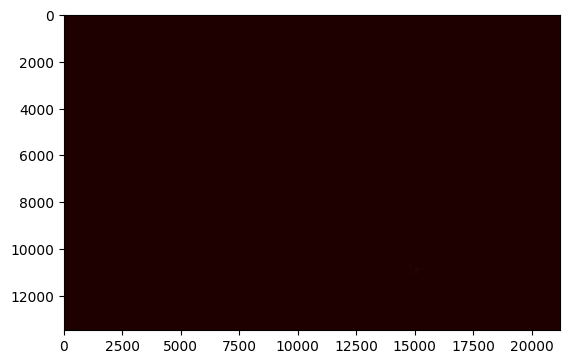

In [123]:
with rasterio.open(output_file, "r") as src:
    print(src.crs)
    print(src.transform)
    print(src.bounds)

    # plt.imshow(src.read(1), cmap="pink")
    # plt.show()

In [126]:
dest_np = np.zeros(intensity.shape, intensity.dtype)

gcps = gcps_from_geolocation_array(asf_data_file0.geolocation_array)

_, dst_transform = reproject(
    intensity,
    destination=dest_np,
    src_transform=None,
    gcps=gcps,
    src_crs="+proj=latlong",
    dst_transform=transform_aff,
    dst_crs="EPSG:4326",
)

r = np.float64(13472.0), c = np.float64(0.0), lat = np.float64(41.08364918328356), lon = np.float64(-120.8396411415921)
r = np.float64(0.0), c = np.float64(21197.0), lat = np.float64(42.74025269372995), lon = np.float64(-121.5156160370133)
r = np.float64(13472.0), c = np.float64(21197.0), lat = np.float64(41.23010369469937), lon = np.float64(-121.8810175432298)
r = np.float64(0.0), c = np.float64(0.0), lat = np.float64(42.59359434337944), lon = np.float64(-120.4492046987991)


### Load data file

In [11]:
file_glob = glob.glob("../data/sentinel-1/*/measurement/*.tiff")

In [12]:
# Select .tiff file and get data
file_path = file_glob[0]
print(file_path)
file_path_p = Path(file_path)
print(file_path_p)

file_stem = file_path_p.stem
print(file_stem)

../data/sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\measurement\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001.tiff
..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\measurement\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001.tiff
s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001


### Locate and load product summary file

In [13]:
product_path = file_path_p.parent.parent
print(product_path)
preview_path = product_path.joinpath("preview")
print(preview_path)
kml_files = glob.glob(f"{str(preview_path)}/*.kml")
kml_file = kml_files[0]
print(kml_file)

..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE
..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\preview
..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\preview\map-overlay.kml


In [14]:
tree = ET.parse(kml_file)
root = tree.getroot()
namespaces = {"gx": "http://www.google.com/kml/ext/2.2"}
coordinates_tag = root.find(".//gx:LatLonQuad/coordinates", namespaces)
coordinates_text = coordinates_tag.text.strip()
coordinates = [
    tuple(map(float, coord.split(","))) for coord in coordinates_text.split()
]

print(coordinates)

[(-120.842606, 41.083923), (-123.8255, 41.476665), (-123.48111, 43.094376), (-120.418518, 42.702103)]


### Locate and load annotation file associated with tiff data

In [7]:
# Find annotation data for measurement file
annotation_path = product_path / "annotation"
annotation_file = annotation_path / f"{file_stem}.xml"
print(annotation_file)

..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\annotation\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001.xml
